# Introduction

This dataset has various wafer resolution with class imbalanced. o I just consider specific subset wafer that has 26x26 resolution.<br> 
and solve imbalance problem using 2D convolutional autoencoder. then, classfy faulty case labels.

### Note
The code below shows the installation of scipy, the feature extractions or more particularly GLCM or scipy only works with this version 
* To run this notebook please
* * Run the !pip unintall scipy -y command
* * Then restart the VM 
* * Run the !pip install scipy==1.10.1

Scipy should not throw out any error 

In [1]:
!pip uninstall scipy -y

Found existing installation: scipy 1.9.3
Uninstalling scipy-1.9.3:
  Successfully uninstalled scipy-1.9.3


In [1]:
!pip install scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 34.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
cuml 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.


# Importation of library

In [2]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


['wm811k-wafer-map']


### Read data

In [3]:
df=pd.read_pickle("/kaggle/input/wm811k-wafer-map/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


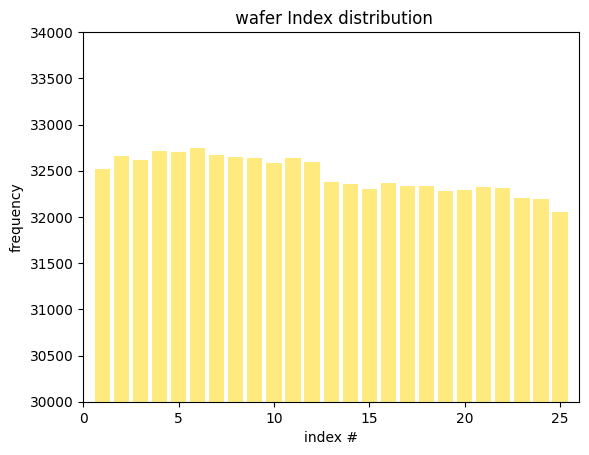

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

* The figure shows that not all lots have perfect 25 wafer maps and it may caused by **sensor failure** or other unknown problems.

* Fortunately, we do not need wafer index feature in our classification so we can just drop the variable. 

In [7]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.


In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
647041,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot40626,[[Test]],[[none]],"(26, 26)"
578376,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",846.0,lot36138,[],[],"(33, 33)"
120520,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...",682.0,lot8079,[],[],"(31, 28)"
661386,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",712.0,lot41225,[],[],"(32, 29)"
221986,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5980.0,lot13994,[],[],"(80, 94)"


# Get wafer with specific resolution & Denoising them

Get wafers of a specific resolution and denoise the images. The denoisng allows for Noise in the image to be reduced such that the model when learning does not get confuse.

In [96]:
sub_df['waferMap'].iloc[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2,
        0, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
        2, 0, 0, 0],
       [0, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 0, 0],
       [0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0],
       [0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
        1, 1, 1, 0],
       [0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 2, 0],
       [1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1],
       [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 

In [98]:
import cv2
import numpy as np

def denoise_wafer_map(wafer_map):
    return cv2.fastNlMeansDenoising(wafer_map, None, 0.75, 3, 3)

sub_df = df.loc[df['waferMapDim'] == (26, 26)]

for i in range(len(sub_df)):
    sub_df['waferMap'].iloc[i] = denoise_wafer_map(sub_df['waferMap'].iloc[i])

sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = []

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])


In [99]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [100]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


plot 1st data for check.

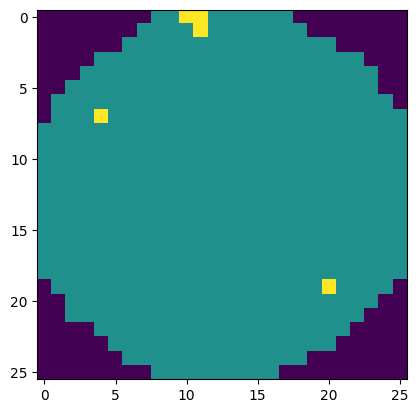

Faulty case : ['none'] 


In [101]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

# Extending the wafer map to a third dimension for later modeling 

We will use 2D Convolutional Autoencoder and extend dimension for channel. The code after will check the data imbalance between the classes

In [102]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [103]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [104]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


### Key idea
Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty. <br>
Extend extra dimension with one-hot-encoded categorical data as channel. <br>
**that idea from Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University**[http://dsba.korea.ac.kr/main]

In [105]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

## Convolutional Autoencoder for augmentation.
The code solves the data imbalance by generating wafer maps of different classes base on the latent space of the auto encoder The code below shows how the wafer maps would look like after generation from the auto encoder 

### ADAMW
AdamW is a variant of Adam that applies weight decay directly to the weights during the update step. In standard Adam, weight decay is incorporated through L2 regularization during the optimization. AdamW has been shown to improve the generalization performance of deep neural networks by reducing overfitting.

The weight decay is the regularization term that reduces the magnitude of the weights during the training process to avoid overfitting. However, standard Adam does not correctly account for weight decay, which can lead to suboptimal performance on some tasks. AdamW explicitly incorporates the weight decay during the update step, which results in improved performance and reduced overfitting.

In [106]:
import tensorflow as tf
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(weight_decay=0.001)

In [107]:
# parameter
epoch=15
batch_size=1024

In [108]:
# Encoder
# As the wafer map has relatively easy to learn features , we would not need a very complex Auto Encoder 
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = optimizer, loss = 'mse')

In [109]:
## start train
ae.fit(new_x, new_x, batch_size=batch_size, epochs=epoch,verbose=2)

Epoch 1/15
15/15 - 1s - loss: 0.1270 - 880ms/epoch - 59ms/step
Epoch 2/15
15/15 - 0s - loss: 0.0287 - 403ms/epoch - 27ms/step
Epoch 3/15
15/15 - 0s - loss: 0.0197 - 399ms/epoch - 27ms/step
Epoch 4/15
15/15 - 0s - loss: 0.0156 - 401ms/epoch - 27ms/step
Epoch 5/15
15/15 - 0s - loss: 0.0128 - 410ms/epoch - 27ms/step
Epoch 6/15
15/15 - 0s - loss: 0.0113 - 397ms/epoch - 26ms/step
Epoch 7/15
15/15 - 0s - loss: 0.0103 - 406ms/epoch - 27ms/step
Epoch 8/15
15/15 - 0s - loss: 0.0096 - 413ms/epoch - 28ms/step
Epoch 9/15
15/15 - 0s - loss: 0.0090 - 398ms/epoch - 27ms/step
Epoch 10/15
15/15 - 0s - loss: 0.0074 - 407ms/epoch - 27ms/step
Epoch 11/15
15/15 - 0s - loss: 0.0065 - 399ms/epoch - 27ms/step
Epoch 12/15
15/15 - 0s - loss: 0.0056 - 406ms/epoch - 27ms/step
Epoch 13/15
15/15 - 0s - loss: 0.0050 - 414ms/epoch - 28ms/step
Epoch 14/15
15/15 - 0s - loss: 0.0046 - 418ms/epoch - 28ms/step
Epoch 15/15
15/15 - 0s - loss: 0.0042 - 488ms/epoch - 33ms/step


In [110]:
# Make encoder model  part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [111]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decoder = models.Model(decoder_input, output_tensor(decode))

In [112]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 1s 1ms/step


# Before and after of adding noise to the data 

Base on the images below we can see that the model accurately generates an wafermap base on the given data with some noise and randomness.

In [113]:
# Add noise to encoded latent faulty wafers vector to simulate unpredictability or randomness in data,we do not want a 1-1 representation of the same thing 
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

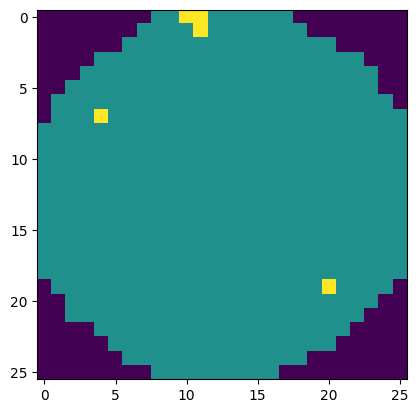

In [114]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[0], axis=2))

449/449 [==============================] - 1s 2ms/step


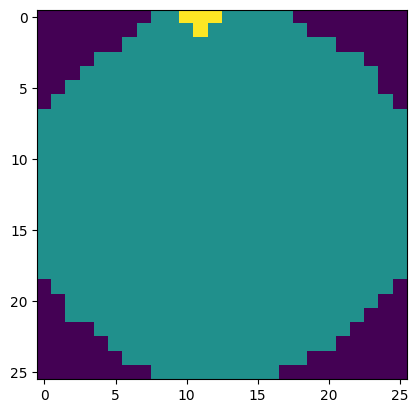

In [115]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[0])

449/449 [==============================] - 1s 2ms/step


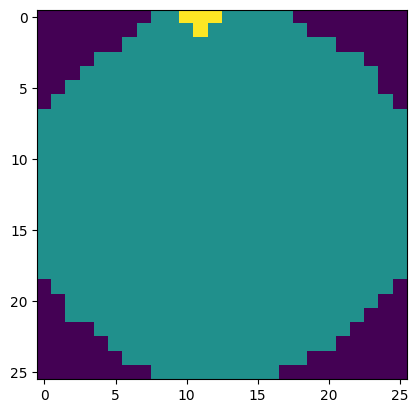

In [116]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[0])

# Data augmentation
This part of the code directly address the data imbalance by generating data through the AE (Auto Encoder)

In [28]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer,verbose=0)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((1700//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)

    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [29]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
      
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], 'Faulty')
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))


3/3 [==============================] - 0s 3ms/step


In [30]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (28182, 26, 26, 3), new_y shape : (28182, 1)


In [31]:
count = 0
for i in y:
    if i == ['none']:
        count +=1 
print(count)

13489


In [32]:
# choice index without replace.
none_idx = np.where(y=='Faulty')[0][np.random.choice(len(np.where(y=='Faulty')[0]), size=3000, replace=False)]

In [33]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [34]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (25182, 26, 26, 3), new_y shape : (25182, 1)


In [35]:
Y = new_y.astype('str')

as we are concatenating the old and the new, the old will still have the various classes 
we need to manually change the classes from the various classes back to the 

In [36]:
V = []
for i in Y:
    if i == ['Edge-Ring'] or i == ['Loc'] or i == 'Center' or i == 'Edge-Loc' or i == 'Donut'or i == 'Random' or i == 'Scratch' or i == 'Near-full':
        i = 'Faulty' 
        V.append(i)
    else:
        V.append(i[0])
        continue
        

In [37]:
new_y = V

In [38]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert strings to numerical labels
label_encoder = LabelEncoder()
num_labels = label_encoder.fit_transform(np.array(new_y).ravel())

# Convert numerical labels to one-hot encoded vectors
onehot_encoder = OneHotEncoder(sparse=False)
new_y = onehot_encoder.fit_transform(num_labels.reshape(-1, 1))


In [39]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,test_size=0.25,random_state=42)

In [40]:
x_test, x_val, y_test,y_val = train_test_split(x_test,y_test,test_size=0.2,random_state=42)

In [41]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (18886, 26, 26, 3), y : (18886, 2)
Test x: (5036, 26, 26, 3), y : (5036, 2)


## Simple 2D CNN Model With Extracted features 
The data is ready. As wafer data is image. simply use cnn for classification.<br>
### Make model
define create model function, because we will validate model with sklearn kfold cross validation.

In [42]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import PIL
import requests
import os
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as jf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
import pathlib

from tensorflow.keras.callbacks import EarlyStopping
from skimage.filters import gabor
from skimage.filters import gabor_kernel
# importing Dependencies

import os
import glob
import pandas as pd 


import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
import tensorflow.keras as keras


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate,Conv2D,MaxPooling2D, Flatten,Dense,BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import NASNetLarge
import os
import numpy as np
from PIL import Image
import cv2

import pywt
import numpy as np

In [43]:
import skimage
from scipy import ndimage
from skimage.measure import shannon_entropy
from scipy.stats import entropy
from skimage.transform import radon
from skimage import io, color, feature, measure

# Feature Extractor 51 outputs 
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity


def feature_extractor(images,count=0):
    image_dataset = pd.DataFrame()
    for img in images:   
        dists = [1]
        angles = [0]
        count +=1 
        print(count,end='\r',flush=True)
        
        
        df = pd.DataFrame()
        # Extract GLCM features for R channel
        glcm_r = skimage.feature.graycomatrix(img[:, :, 0], dists, angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for G channel
        glcm_g = skimage.feature.graycomatrix(img[:, :, 1],dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for B channel
        glcm_b = skimage.feature.graycomatrix(img[:, :, 2], dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for RG channel
        img_rg = np.zeros((img.shape[0], img.shape[1], 2))
        img_rg[:, :, 0] = img[:, :, 0]
        img_rg[:, :, 1] = img[:, :, 1]
        img_rg_8bit = img_rg[:,:,1].astype(np.uint8)
        glcm_rg = skimage.feature.graycomatrix(img_rg_8bit, dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for RB channel
        img_rb = np.zeros((img.shape[0], img.shape[1], 2))
        img_rb[:, :, 0] = img[:, :, 0]
        img_rb[:, :, 1] = img[:, :, 2]
        img_rb_8bit = img_rb[:,:,1].astype(np.uint8)
        glcm_rb = skimage.feature.graycomatrix(img_rb_8bit, dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for GB channel
        img_gb = np.zeros((img.shape[0], img.shape[1], 2))
        img_gb[:, :, 0] = img[:, :, 1]
        img_gb[:, :, 1] = img[:, :, 2]
        img_gb_8bit = img_gb[:,:,1].astype(np.uint8)
        glcm_gb = skimage.feature.graycomatrix(img_gb_8bit, dists,  angles, 256, symmetric=True, normed=True)
        
          
                    
#         # Gabor filter parameters, Run if you are on a Ryzen ThreadRipper 5000
#         sigmas = (1, 3)
#         thetas = np.deg2rad([0, 45, 90, 135])
#         frequencies = (0.05, 0.25)
#         psis = np.pi/2
        
#         # Create a list of Gabor filter kernels for each color channel
#         kernels = []
#         for sigma in sigmas:
#             for theta in thetas:
#                 for frequency in frequencies:
#                     kernel = []
#                     for color in range(3):
#                         kernel.append(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma/0.5, n_stds=3)))
#                     kernels.append(kernel)
        
#         # Apply each Gabor filter kernel to the image channels and get the mean response
#         for i, kernel in enumerate(kernels):
#             filtered = []
#             for j in range(3):
#                 filtered_channel = ndimage.convolve(img[:, :, j], kernel[j], mode='constant', cval=0)
#                 filtered.append(filtered_channel)
#             filtered = np.mean(filtered, axis=0)
#             df[f'gabor_{i}'] = [filtered.mean()]
            #print(filtered.mean())
    
    
        # R,G,B,RG,GB,BR 
        # Extract the contrast, correlation, energy, and homogeneity properties
        for i, glcm in enumerate([glcm_r, glcm_g, glcm_b, glcm_rg, glcm_rb, glcm_gb]):
            df[f'contrast_{i}'] = skimage.feature.graycoprops(glcm, 'contrast')[0]
            df[f'correlation_{i}'] = skimage.feature.graycoprops(glcm, 'correlation')[0]
            df[f'energy_{i}'] = skimage.feature.graycoprops(glcm, 'energy')[0]
            df[f'homogeneity_{i}'] = skimage.feature.graycoprops(glcm, 'homogeneity')[0]
            df[f'dissimilarity_{i}'] = skimage.feature.graycoprops(glcm, 'dissimilarity')[0]
            df['Entropy_glcm_r'] = shannon_entropy(img[:, :, 0])
            df['Entropy_glcm_g'] = shannon_entropy(img[:, :, 1])
            df['Entropy_glcm_b'] = shannon_entropy(img[:, :, 2])
            df['Entropy_glcm_rg'] = shannon_entropy(img_rg_8bit)
            df['Entropy_glcm_gb'] = shannon_entropy(img_gb_8bit)           
            df['Entropy_glcm_rb'] = shannon_entropy(img_rb_8bit)
        
        # RGB
        # Entropy
        df['Entropy_glcm_rgb'] = shannon_entropy(img)
        
        #RADON 
        #The Radon transform is a mathematical transform that is commonly used in image processing, medical imaging, and other related fields. It is a technique for converting a 2D image into a series of 1D projections that capture the image's intensity values along a specific angle.

        theta = np.linspace(0., 180., max(img[:,:,0].shape), endpoint=False)
        df['sinogram_std'] = radon(img[:,:,0], theta=theta).std()
        df['sinogram_mean'] = radon(img[:,:,0], theta=theta).mean()
        # Grayscale
        # Geometric properties, wavelets 
        
        for o in range(len(fea_geom(img[:,:,0]))):          
            df[f'Geometric_Extraction_{o}'] = fea_geom(img[:,:,0])[o]
                
#         # Extract the approximation, horizontal, vertical, and diagonal coefficients    
#         coeffs = pywt.dwt2(img[:,:,0], 'haar')
#         cA, (cH, cV, cD) = coeffs
#         df['cA_mean'] = cA.mean()
#         df['cH_mean'] = cH.mean()
#         df['cV_mean'] = cV.mean()
#         df['cD_mean'] = cD.mean()
#         df['cA_std'] = cA.std()
#         df['cH_std'] = cH.std()
#         df['cV_std'] = cV.std()
#         df['cD_std'] = cD.std()

        image_dataset = image_dataset.append(df, ignore_index=True)

    return image_dataset

In [44]:
# Run Feature Extractor
x_train_uint = x_train.astype(np.uint8)
train_extr_features = feature_extractor(x_train_uint)
x_test_uint = x_test.astype(np.uint8)
test_extr_features = feature_extractor(x_test_uint)
x_val_unit8 = x_val.astype(np.uint8)
val_extr_features = feature_extractor(x_val_unit8)

In [45]:
from sklearn import preprocessing
train_extr_features = preprocessing.MinMaxScaler().fit_transform(train_extr_features)
test_extr_features = preprocessing.MinMaxScaler().fit_transform(test_extr_features)
val_extr_features = preprocessing.MinMaxScaler().fit_transform(val_extr_features)

In [52]:
def build_autoencoder():
    model = keras.Sequential()
    input_layer = keras.Input(shape=(45,), name='Input')
    
    # Encoder
    encoded = keras.layers.Dense(128, activation='relu')(input_layer)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Dense(64, activation='relu')(encoded)
    encoded = keras.layers.Dropout(0.2)(encoded)
    encoded = keras.layers.Dense(16, activation='relu')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Dense(16, activation='relu')(encoded)
    
    # Define the model
    model = keras.Model(inputs=input_layer, outputs=encoded)
    return model


def build_cnn(input_shape):
    input_tensor = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    output_tensor = layers.Dense(64, activation='relu')(x)
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model



In [53]:
input_shape = (26, 26, 3)
cnn = build_cnn(input_shape)

DMLP = build_autoencoder()
combinedInput = concatenate([DMLP.output, cnn.output])

x = Dense(64, activation="relu")(combinedInput)
keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.27)(x)
x = Dense(16, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(4, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.05)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[DMLP.input, cnn.input], outputs=x)

In [54]:
def label_smoothing(y_true,y_pred):
    
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.1)

In [55]:
from keras import backend as K



model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['binary_accuracy'])


### Cross validate model
Using sklearn KFold Cross validation, we validate our simple cnn.

In [50]:
# Look towards the given class practice under RUL ipynb 

# Application of Label smoothing to prevent overfitting 

In [56]:
history = model.fit(x=[train_extr_features, x_train],y=y_train[:,0],epochs = 5 ,validation_data=([test_extr_features,x_test],y_test[:,0]))

Epoch 1/5
591/591 [==============================] - 13s 18ms/step - loss: 0.1026 - binary_accuracy: 0.9693 - val_loss: 1.8733 - val_binary_accuracy: 0.4619
Epoch 2/5
591/591 [==============================] - 10s 17ms/step - loss: 0.0712 - binary_accuracy: 0.9822 - val_loss: 0.3700 - val_binary_accuracy: 0.8582
Epoch 3/5
591/591 [==============================] - 10s 16ms/step - loss: 0.0671 - binary_accuracy: 0.9816 - val_loss: 3.4472 - val_binary_accuracy: 0.4619
Epoch 4/5
591/591 [==============================] - 10s 16ms/step - loss: 0.0657 - binary_accuracy: 0.9827 - val_loss: 0.0990 - val_binary_accuracy: 0.9784
Epoch 5/5
591/591 [==============================] - 10s 17ms/step - loss: 0.0656 - binary_accuracy: 0.9836 - val_loss: 0.3543 - val_binary_accuracy: 0.9551


In [ ]:
score = model.evaluate([val_extr_features,x_val],y=y_val[:,0], batch_size=16, steps=200 )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
y_pre = model.predict([val_extr_features,x_val])
print(accuracy_score(y_val[:,0],np.round(y_pre)))

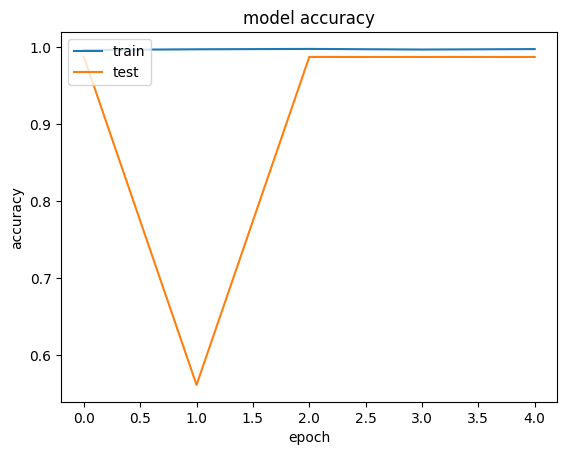

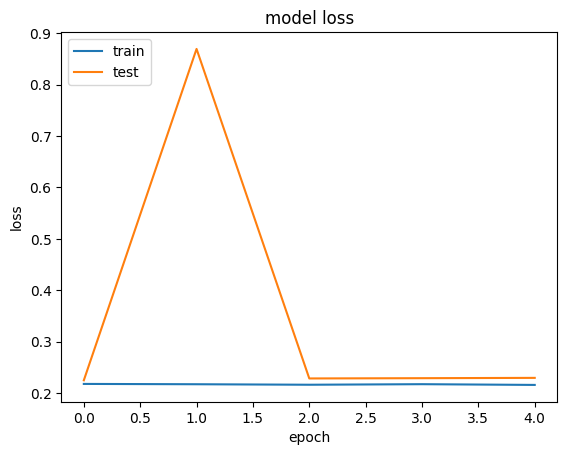

In [67]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
features = model.predict([train_extr_features, x_train])

591/591 [==============================] - 2s 3ms/step


In [94]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error

y_pred = model.predict([val_extr_features,x_val])
# Define a threshold probability value
threshold = 0.5

# Convert probabilities to class labels
y_pred_classes = np.zeros_like(y_pred, dtype=int)
y_pred_classes[y_pred > threshold] = 1

score1 = accuracy_score(y_val[:,0],y_pred_classes)
score2 = precision_score(y_val[:,0], y_pred_classes, average='macro')
score3 = recall_score(y_val[:,0], y_pred_classes, average='macro')

print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))
print('F1 Score:',f1_score(y_val_binary, y_pred_classes, average='macro'))

40/40 [==============================] - 0s 3ms/step


Accuracy is  98.97 %
Precision is  0.99
Recall is  0.99
F1 Score: 0.010301875501944792


In [95]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Extract features from the input data using the CNN model
train_features = model.predict([train_extr_features, x_train])
val_features = model.predict([val_extr_features, x_val])

# Build the XGBoost model to classify the input data based on the extracted features
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features, y_train[:,0])

# Make predictions on the validation data using the XGBoost model
y_val_pred = xgb_model.predict(val_features)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_val[:,0], y_val_pred)
print(f'Test accuracy: {accuracy}')


40/40 [==============================] - 0s 3ms/step
Test accuracy: 0.9888888888888889


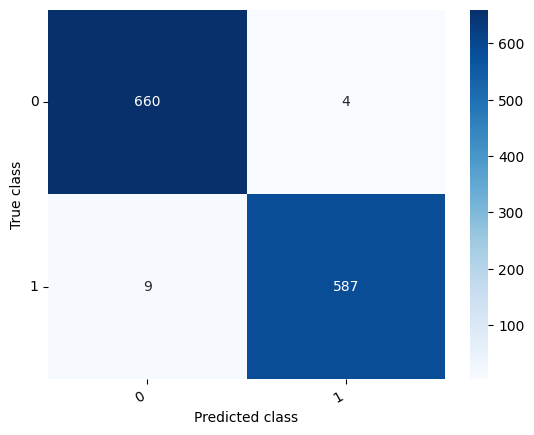

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_val[:,0], y_pred_classes)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

# PPO

In [ ]:
!pip install stable-baselines3
!pip install gym
!pip install opencv-python
!pip install torch
!pip install tensorflow
!pip install keras

In [ ]:
# Define the checkpoint callback
from stable_baselines3.common.callbacks import CheckpointCallback
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='/kaggle/working/', name_prefix='ppo_mnist')

In [ ]:
import time
import gym
import random
import numpy as np
from tensorflow import keras
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.logger import configure

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Model / data parameters
num_classes = 9
input_shape = (26, 26,3)




class MnistEnv(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(x_train, y_train[:,0]), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(9)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=(26,26,3),
                                                dtype=np.float32)

        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs


def mnist_ppo():
    env = DummyVecEnv([lambda: Monitor(MnistEnv(images_per_episode=1), './logs/mnist_ppo')])

    model = PPO(
        'MlpPolicy',
        env,
        verbose=1,
        n_steps=32,
        ent_coef=0.01,
        learning_rate=2.5e-4,
        batch_size=256,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2
    )

    model.learn(total_timesteps=int(1.2e5), callback=checkpoint_callback)
    return model


ppo_model =mnist_ppo()

In [ ]:
def mnist_ppo_eval(ppo_model):
    attempts, correct = 0,0

    env = DummyVecEnv([lambda: MnistEnv(images_per_episode=1, dataset=(x_test, y_test[:,0]), random=False)])
    
    try:
        while True:
            obs, done = env.reset(), [False]
            while not done[0]:
                action, _ = ppo_model.predict(obs)
                obs, rew, done, _ = env.step(action)

                attempts += 1
                if rew[0] > 0:
                    correct += 1

    except StopIteration:
        print()
        print('validation done...')
        print('Accuracy: {0}%'.format((float(correct) / attempts) * 100))

mnist_ppo_eval(ppo_model)

# Isolation Forest change to respective classes not 1s and zeros

Not so accurate : 700 + short 

In [98]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [113]:
df_num = pd.DataFrame(val_extr_features)

In [114]:
clf=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(.1),\
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df_num)

IsolationForest(contamination=0.12, n_estimators=150, n_jobs=-1,
                random_state=42)

In [115]:
pred = clf.predict(df_num)
df_num['anomaly']=pred
print(pred) # -1 indicates anomaly

[ 1 -1  1 ...  1  1  1]


In [116]:
outliers=df_num.loc[df_num['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_num['anomaly'].value_counts())

 1    1108
-1     152
Name: anomaly, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions

scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(df_num)

#fit the metrics to PCA model with X and apply the dimensionality reduction on X.
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

# AE & GANS

## AE

In [ ]:
# AE

# Build the autoencoder model
input_layer = tf.keras.layers.Input(shape=(df_num.shape[1],))
encoded = tf.keras.layers.Dense(128, activation="relu")(input_layer)
encoded = tf.keras.layers.Dense(64, activation="relu")(encoded)
decoded = tf.keras.layers.Dense(128, activation="relu")(encoded)
decoded = tf.keras.layers.Dense(df_num.shape[1], activation="sigmoid")(decoded)

autoencoder = tf.keras.models.Model(input_layer, decoded)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(df_num, df_num, epochs=100, batch_size=64)

In [ ]:
predictions = autoencoder.predict(df_num)

reconstruction_error = np.mean((predictions - df_num)**2, axis=1) # mean squared error

predictions

In [ ]:
# Threshold the reconstruction error to identify anomalies
threshold = np.mean(reconstruction_error) + 3 * np.std(reconstruction_error)

anomalies = np.where(reconstruction_error > threshold)
anomalies

In [ ]:
anomaly_data = df_num.iloc[[i for i in anomalies[0]]]
anomaly_data

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])



In [ ]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)
5. Visualize the latent representations : Fraud Vs Non Fraud
Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases.

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

# GANS

In [ ]:
# GANS

#-----------------------------------------------------------------------------------
# Build the generator model - GAN
generator = tf.keras.Sequential()
generator.add(tf.keras.layers.Dense(64, input_dim=100, activation="relu"))
generator.add(tf.keras.layers.Dense(128, activation="relu"))
generator.add(tf.keras.layers.Dense(df_num.shape[1], activation="sigmoid"))

# Build the discriminator model
discriminator = tf.keras.Sequential()
discriminator.add(tf.keras.layers.Dense(128, input_dim=df_num.shape[1], activation="relu"))
discriminator.add(tf.keras.layers.Dense(64, activation="relu"))
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# Compile the discriminator
discriminator.compile(optimizer="adam", loss="binary_crossentropy")
# Freeze the discriminator weights
discriminator.trainable = False

In [ ]:
# Build the combined model
inputs = tf.keras.layers.Input(shape=(100,))
generated_data = generator(inputs)
validity = discriminator(generated_data)

gan = tf.keras.models.Model(inputs, validity)

gan.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
# Train the GAN
for epoch in range(100):

  # Generate synthetic data
  noise = np.random.normal(0, 1, (df_num.shape[0], 100))
  synthetic_data = generator.predict(noise)

  # Train the discriminator on real data and synthetic data
  real_labels = np.ones((df_num.shape[0], 1))
  synthetic_labels = np.zeros((df_num.shape[0], 1))

  d_loss_real = discriminator.train_on_batch(df_num, real_labels)
  d_loss_synthetic = discriminator.train_on_batch(synthetic_data, synthetic_labels)

  # Train the generator
  g_loss = gan.train_on_batch(noise, real_labels)
  
  # Print the loss values for each epoch
  print("Epoch: %d, D Loss (real): %.4f, D Loss (synthetic): %.4f, G Loss: %.4f" % (epoch + 1, d_loss_real, d_loss_synthetic, g_loss))

In [ ]:
# Evaluate the synthetic data using the discriminator
scores = discriminator.predict(df_num)

# Threshold the scores to identify anomalies
threshold = np.mean(scores) - 3 * np.std(scores)
#threshold = 0.3

anomalies = np.where(scores < threshold)
anomalies

In [ ]:
anomaly_data = df_num.iloc[[i for i in anomalies[0]]]
anomaly_data

In [ ]:
y_train

In [ ]:
y_train_int = np.argmax(y_train, axis=1)

In [ ]:
y_test_int = np.argmax(y_test, axis=1)

In [ ]:
y_train_int

#  SVM

In [ ]:
# ---multicalss classification ---# 
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LinearSVC(random_state = 42)).fit(train_extr_features, y_train_int)
y_train_pred = clf2.predict(train_extr_features)
y_test_pred = clf2.predict(test_extr_features)
y_test_pred = clf2.predict(test_extr_features)
train_acc2 = np.sum(y_train_int == y_train_pred, axis=0, dtype='float') / train_extr_features.shape[0]
test_acc2 = np.sum(y_test_int == y_test_pred, axis=0, dtype='float') / test_extr_features.shape[0]
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train[:100]: ", y_train_int[:100])